Unzip the dataset compressed files in /dataset. They are divided in speech and song.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")

SONG_DATASET_FOLDER = os.path.join(TS_DATASET_FOLDER,"Audio_Song_Actors_01-24")
SPEECH_DATASET_FOLDER = os.path.join(TS_DATASET_FOLDER,"Audio_Speech_Actors_01-24")

TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

def get_actor_files(vc, actor_n):
    fold = SONG_DATASET_FOLDER if vc == "song" else SPEECH_DATASET_FOLDER
    act_fold = f"Actor_{str(actor_n).zfill(2)}"
    fold = os.path.join(fold, act_fold )
    return [os.path.join(fold,f) for f in os.listdir(fold) if f.endswith(".wav")]


CATEGORICAL_FEATURES_NAMES = {
    "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"}, 
    "vocal_channel": {"01": "speech", "02": "song"},
    "emotion": {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : "fearful", "07" : "disgust", "08" : "surprised"},
    "emotional_intensity": {"01" : "normal", "02" : "strong"},
    "statement": {"01" : "kids", "02" : "dogs"},
    "repetition": {"01" : "1st", "02" : "2nd"},
    "actor": {str(i).zfill(2): str(i).zfill(2) for i in range(1, 25)}
}

SAMPLING_RATE = 48_000
DECIMATION_FACTOR = 8

def recompute_numeric_categorical(df):
    global numerical_attr_list, categorical_attr_list
    numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
    categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]
    
# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

# File import
Files must be downsampled before being saved in memory because they are enormous (200_000 floating point numbers, roughly 0.5 MB)

In [2]:
# Loads the audio traces
import sys
from scipy.signal import decimate

df = pd.DataFrame(columns = list(CATEGORICAL_FEATURES_NAMES.keys()) + ["audio_trace", "path"])
for vc in ["speech", "song"]:
    for actor_n in tqdm(range(1,25)):
        for f in get_actor_files(vc, actor_n):
            segment, sr = librosa.load(f, sr=None)
            segment = decimate(segment, q=DECIMATION_FACTOR)

            categ_values = str(os.path.basename(f)).strip(".wav").split("-")
            
            # Deduces attributes from file name
            row = {attr:val for attr, val in zip(CATEGORICAL_FEATURES_NAMES.keys(), categ_values)}
            row["audio_trace"] = [segment]
            row["path"] = f
            row = pd.DataFrame(row, index = [0])
            df = pd.concat([df,  row], ignore_index=True)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [3]:
# Assigns sex
for column in df.columns:
    df = df.replace(CATEGORICAL_FEATURES_NAMES)

df["sex"] = ["F" if i % 2 == 0 else "M" for i in df["actor"].astype(int)]
df = df.replace({ "actor": {str(i).zfill(2): f"actor_{str(i).zfill(2)}" for i in range(1, 25)}})
df = df.drop(columns = ["modality"])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,audio_trace,path,sex
0,speech,happy,normal,kids,2nd,actor_01,"[6.7432594e-11, -1.7281297e-10, 2.6411556e-10,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
1,speech,calm,strong,dogs,2nd,actor_01,"[-5.096353e-09, 7.548913e-09, -8.45547e-09, 6....",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
2,speech,fearful,normal,kids,2nd,actor_01,"[0.00011891391, 0.00010525208, 6.3990985e-05, ...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
3,speech,neutral,normal,kids,2nd,actor_01,"[-2.9781221e-08, -1.4013209e-06, -1.0139452e-0...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
4,speech,calm,normal,kids,1st,actor_01,"[3.0153627e-05, -4.7941107e-06, 1.3743208e-06,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M


## Preprocessing

### Trimming
Trailing and leading silences are removed when short-time intensity overcomes the 5% threshold

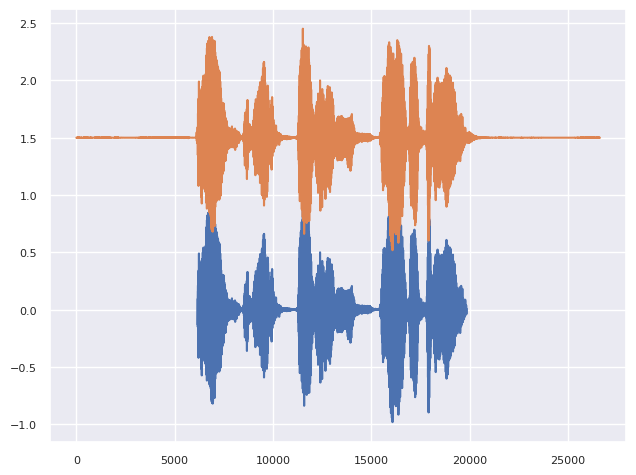

In [4]:
def trim_silence(track, window_in_ms=10.0, rel_thr=1e-2):
    ts = pd.Series(track)
    window = int(window_in_ms*1e-3*SAMPLING_RATE/DECIMATION_FACTOR )
    rolling_std = ts.rolling(window=window).std()
    mask = rolling_std > rel_thr*rolling_std.max()
    begin, end = np.where(mask)[0][0], np.where(mask)[0][-1]
    return track[begin:end], begin, end

trimmed, begin, end = trim_silence(df["audio_trace"][50],  rel_thr=5e-2)
plt.plot(np.arange(begin, end), trimmed)
plt.plot(df["audio_trace"][50] + 1.5)

Add to the dataset the trimmed tracks

In [5]:
trimmed_df = pd.DataFrame(columns=["trimmed_trace", "begin_s", "end_s"])
for tr in df.audio_trace:
    trimmed, begin, end = trim_silence(tr, rel_thr=5e-2)
    row = dict( trimmed_trace=[trimmed], 
                begin_s=begin/SAMPLING_RATE*DECIMATION_FACTOR, 
                end_s=end/SAMPLING_RATE*DECIMATION_FACTOR)
    row = pd.DataFrame(row, index=[0])
    trimmed_df = pd.concat([trimmed_df, row], ignore_index=True)

try:
    df.drop(columns=["trimmed_trace", "begin_s", "end_s"], inplace=True)
except KeyError as e:
    print(e)
    pass

df = df.join(trimmed_df)

"['trimmed_trace', 'begin_s', 'end_s'] not found in axis"


check if the distribution of start time/ end time is related to actors' reactivity

Text(0.5, 1.0, 'distribution of leading silence duration')

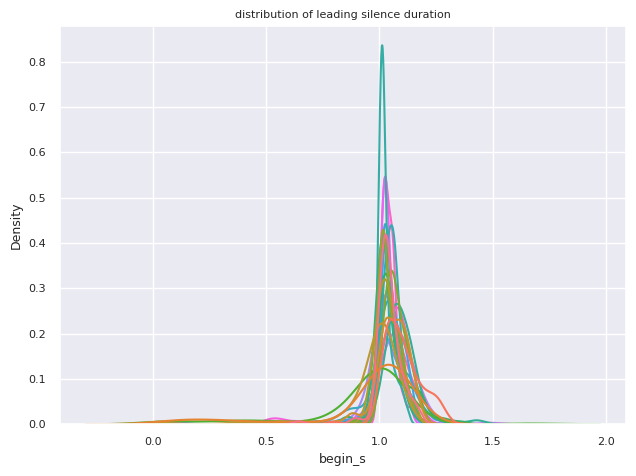

In [6]:
sns.kdeplot(data =df, x="begin_s", hue="actor", legend=False);
plt.title("distribution of leading silence duration")

### Detrending

Removes a linear trend form the trimmed trace

In [7]:
# First check if relevant linear trend is present
from sklearn.linear_model import LinearRegression
coeffs, intercepts = [], []
for trace in df.trimmed_trace:
    subsamp_trace = decimate(trace, q=8)
    model = LinearRegression()
    model.fit(np.arange(len(subsamp_trace)).reshape(-1,1), subsamp_trace)
    coeffs.append(model.coef_)
    intercepts.append(model.intercept_)
print(np.mean(coeffs), np.mean(intercepts))

3.0473035542034983e-08 -1.704989029028754e-05


Even if it doesn't seem to be relevant, I remove the trend anyway

In [8]:
from scipy.signal import detrend
detrended_traces = pd.DataFrame(columns=["detrended_trace"])
for trace in df.trimmed_trace:
    row = dict(detrended_trace=[detrend(trace)])
    row = pd.DataFrame(row, index=[0])
    detrended_traces = pd.concat([detrended_traces, row], ignore_index=True)
    
try:
    df.drop(columns=["detrended_trace"], inplace=True)
except KeyError as e:
    print(e)
    pass
df = df.join(detrended_traces)

"['detrended_trace'] not found in axis"


### Denoising

Two types of denoising are compared:

- rolling window mean
- lowpass filter

#### Rolling window
The rolling window basically computes ($f(t)$ is the audio trace and $g(t)$ is the denoised one):

$$g(t) = \frac{1}{T}\int_{t-T}^t f(s) ds$$

or even more accurately, given the box function:

$$\chi(s) = \begin{cases}\frac{1}{T} \;\; \mathrm{if} \;\;0<s<T\\0\;\; \mathrm{otherwise}\end{cases}$$

then $g(t)$ is the convolution product of $g$ and $\chi$:

$$g(t) = \int_{-\infty}^{+\infty}f(t)g(t-s)ds$$

implying that the Fourier transform of $g$ is the product of Fourier transforms of $f$ and $\chi$. The Fourier transform of $\chi$ is roughly a $sinc(\omega)=\frac{\sin \omega}{\omega} $, so distortion is applied.

#### Lowpass filter

Denoising is performed simulating an RC circuit (like the "tone" potentiometer of electric guitars).
The transfer function of an RC circuit in lowpass mode is given by:

$$G(f) = \frac{f_0}{\sqrt{f_0^2 + f^2}}$$

where $f_0$ is the cutting frequency. The denoising is performed by inverse transform of the fourier transform of the signal multiplied by the transfer function:

$$g(t) = \mathcal{F}^{-1}[ G(\omega) \cdot \tilde{f}(\omega) ]$$

To mantain code generality I wrote a code that works with many "orders" (i.e. exponents) of the same kind:

$$G(f) = \frac{f_0}{(f_0^n + f^n)^{1/n}}$$



In [9]:
from scipy.fft import fft, fftfreq, ifft
denoised_traces = pd.DataFrame(columns=["window_denoised_trace", 
                                        "lowpass_denoised_trace", 
                                        "fourier_coeffs", 
                                        "filtered_fourier_coeffs",
                                        "window_fourier_coeffs"])

DENOISING_WINDOW=20
F0 = 500
DENOISING_FILTER_ORDER = 2


for norm_trace in df.detrended_trace:
    row = dict()
    
    # Window denoising
    row["window_denoised_trace"] = [np.convolve(norm_trace, np.ones(DENOISING_WINDOW)/DENOISING_WINDOW, mode='valid')]
    
    # Fourier lowpass denoising
    signal_f = fft(norm_trace)
    N, T = len(norm_trace), DECIMATION_FACTOR/SAMPLING_RATE
    attenuation = (F0/(F0**DENOISING_FILTER_ORDER + fftfreq(N, T)**DENOISING_FILTER_ORDER )**(1/DENOISING_FILTER_ORDER)).astype(np.complex64)
    signal_f *= attenuation
    row["lowpass_denoised_trace"] = [np.real(ifft(signal_f))]
    
    # Save the fourier coefficients
    row["filtered_fourier_coeffs"] = [np.abs(signal_f[:N//2])]
    row["fourier_coeffs"] = [np.abs(fft(norm_trace)[:N//2])]
    row["window_fourier_coeffs"] = [np.abs(fft(row["window_denoised_trace"][0])[:N//2])]

    
    row = pd.DataFrame(row, index=[0])
    denoised_traces = pd.concat([denoised_traces, row], ignore_index=True)

try:
    df.drop(columns=["window_denoised_trace", "lowpass_denoised_trace", "fourier_coeffs", "filtered_fourier_coeffs", "window_fourier_coeffs"], inplace=True)
except KeyError as e:
    pass
display(denoised_traces.head())
df = df.join(denoised_traces)

,window_denoised_trace,lowpass_denoised_trace,fourier_coeffs,filtered_fourier_coeffs,window_fourier_coeffs
0,"[0.0012597332242876291, 0.002419694559648633, ...","[-0.00396774, -0.0048647174, -0.0054989755, -0...","[5.9604645e-08, 0.09244833, 0.07012002, 0.0596...","[5.9604645e-08, 0.092448264, 0.07011981, 0.059...","[0.0191793138768164, 0.08003642830301287, 0.05..."
1,"[-0.00032312453686245135, -0.00029447021797750...","[-0.0010340745, -0.0013757215, -0.0016943084, ...","[3.3713877e-07, 0.006099066, 0.008331736, 0.00...","[3.3713877e-07, 0.0060990625, 0.008331719, 0.0...","[0.004021015576017735, 0.006094360534815384, 0..."
2,"[-0.004694556753383949, -0.004789868224179371,...","[0.0040936237, 0.004391336, 0.0039263847, 0.00...","[4.5448542e-07, 0.022871135, 0.021308422, 0.02...","[4.5448542e-07, 0.022871116, 0.021308355, 0.02...","[0.01218381713942987, 0.016927737617833276, 0...."
3,"[0.0016524663777090606, 0.0011103632743470371,...","[0.0035621957, 0.0050409036, 0.0058340705, 0.0...","[3.501773e-07, 0.026199006, 0.025683409, 0.022...","[3.501773e-07, 0.02619897, 0.025683273, 0.0222...","[0.04482997534923934, 0.02045641639757924, 0.0..."
4,"[-4.451542445167433e-05, -0.000100842056781402...","[0.00031803624, -0.00010107233, -0.0004460984,...","[1.1920929e-07, 0.0020026919, 0.0007968909, 0....","[1.1920929e-07, 0.0020026902, 0.0007968881, 0....","[0.002927426724551277, 0.002106893023791371, 0..."


Plot a nice summary of these two methods

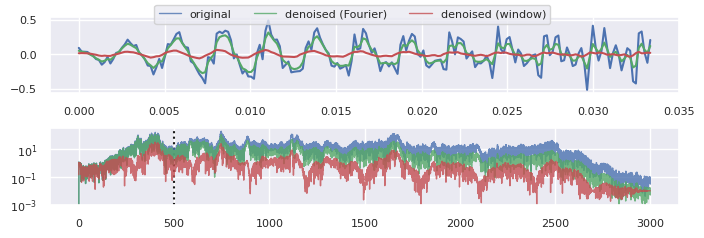

In [10]:
test_track = 50
plot_time_start, plot_time_end = 0, 200

N, T = len(df["detrended_trace"][test_track]), DECIMATION_FACTOR/SAMPLING_RATE
freqs = fftfreq(N,T)[:N//2]
plot_time = np.linspace(plot_time_start*T,plot_time_end*T,plot_time_end-plot_time_start)

fig, (axt, axf) = plt.subplots(2,1, figsize=default_style.SHORT_FULLSIZE_FIGURE)
axf.set_yscale("log")
axf.set_ylim(1e-3, 3e2)
axf.axvline(F0, ls=":", color="k")
style = dict(alpha=0.8, lw=1)

# Normalized
signal = df["detrended_trace"][test_track]
display(Audio(signal, rate=SAMPLING_RATE/DECIMATION_FACTOR))
axt.plot(plot_time, signal[plot_time_start:plot_time_end],  color="b")
axf.plot(freqs, 
         df["fourier_coeffs"][test_track], 
         label="original", 
         color="b", **style)

# FFT denoising
signal = df["lowpass_denoised_trace"][test_track]
display(Audio(signal, rate=SAMPLING_RATE/DECIMATION_FACTOR))
axt.plot(plot_time, signal[plot_time_start:plot_time_end],color="g")
axf.plot(freqs, 
         df["filtered_fourier_coeffs"][test_track], 
         label="denoised (Fourier)", 
         color="g", **style)

# Window denoising
signal = df["window_denoised_trace"][test_track]
display(Audio(signal, rate=SAMPLING_RATE/DECIMATION_FACTOR))
axt.plot(plot_time, signal[plot_time_start:plot_time_end], color="r")
axf.plot(freqs, 
         df["window_fourier_coeffs"][test_track],
         label="denoised (window)",
         color="r", **style)


fig.legend(ncols=3, loc="upper center")
fig.tight_layout()
fig.savefig(os.path.join("..", "images/denoising.pdf"))

### Amplitude Normalization
Is performed on denoised tracks instead of detrended traces. Is really a z-score normalization.

In [11]:
clean_traces = pd.DataFrame(columns = ["clean_trace"])
for den_trace in df.lowpass_denoised_trace:
    row = dict(clean_trace=[(den_trace - np.mean(den_trace))/np.std(den_trace)])
    row = pd.DataFrame(row, index=[0])
    clean_traces = pd.concat([clean_traces, row], ignore_index=True)
try:
    df.drop(columns=["clean_trace"], inplace=True)
except KeyError as e:
    print(e)
    pass
df = df.join(clean_traces)

"['clean_trace'] not found in axis"


In [12]:
Audio(df["clean_trace"][0], rate=SAMPLING_RATE/DECIMATION_FACTOR)

In [13]:
# Clean some columns since they take space
df.drop(columns=[ "detrended_trace",
                 "trimmed_trace",
                "audio_trace",
                 "lowpass_denoised_trace",
                "window_denoised_trace",
                "window_fourier_coeffs",
                ], inplace=True)

recompute the numerical attribute list

In [14]:
print(f"dataset size is {sys.getsizeof(df)/1e6} MB")
recompute_numeric_categorical(df)
df.head()

dataset size is 245.0272 MB


,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,clean_trace
0,speech,happy,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.061167,2.701833,"[5.9604645e-08, 0.09244833, 0.07012002, 0.0596...","[5.9604645e-08, 0.092448264, 0.07011981, 0.059...","[-0.4510565, -0.5530258, -0.6251288, -0.595908..."
1,speech,calm,strong,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.020167,2.983000,"[3.3713877e-07, 0.006099066, 0.008331736, 0.00...","[3.3713877e-07, 0.0060990625, 0.008331719, 0.0...","[-0.27899316, -0.37116948, -0.45712417, -0.386..."
2,speech,fearful,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.057000,2.642500,"[4.5448542e-07, 0.022871135, 0.021308422, 0.02...","[4.5448542e-07, 0.022871116, 0.021308355, 0.02...","[0.38889256, 0.41717508, 0.3730049, 0.27802384..."
3,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,"[3.501773e-07, 0.026199006, 0.025683409, 0.022...","[3.501773e-07, 0.02619897, 0.025683273, 0.0222...","[0.6488597, 0.91820866, 1.0626854, 1.1574861, ..."
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,"[1.1920929e-07, 0.0020026919, 0.0007968909, 0....","[1.1920929e-07, 0.0020026902, 0.0007968881, 0....","[0.08771753, -0.027876738, -0.12303832, -0.159..."


## Short-time intensity traces

Short-time intensity traces are the standard deviations of a rolling window:

$$\sigma^2(t) = \langle f(t)^2 \rangle_{t, t+T} - (\langle f(t) \rangle_{t, t+T})^2 $$

They will be called phonetic traces since they (by their very definition) cannot grasp information about the tone and the phase, it's just intensity.


#### API
Since some methods are useful to manage the whole bunch of phonetic traces, I wrote a small script called `phonetic_stuff.py`

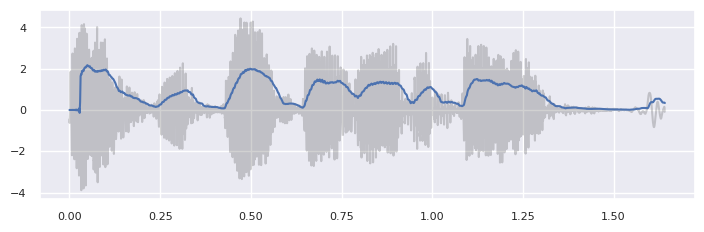

In [53]:
from phonetic_stuff import PhoneticList

# Initializes the phonetic list
ph_list = PhoneticList.from_tracks(df.clean_trace, 
                                   [SAMPLING_RATE/DECIMATION_FACTOR]*len(df), 
                                   30.0, # This is the time window of smoothing
                                   decimate=8)
# Plots a track
fig, ax = plt.subplots(figsize=default_style.SHORT_FULLSIZE_FIGURE)
plt.plot(ph_list.source_times[0], ph_list.source_tracks[0], alpha=0.2, color="k")
plt.plot(ph_list.times[0], ph_list.tracks[0])

The trace of short-time intensity has different length for each record, so it must be standardised:

In [66]:
# Standardises length of short-time intensity
std_phon = ph_list.standardize_length(length=700)
display(std_phon.head())

,standard_phonetic_trace,time_rescale
0,"[0.061339872340656895, 0.0626889018611586, 0.0...",1.758571
1,"[0.03276149567103439, 0.03263537881919294, 0.0...",2.104286
2,"[0.0025068948397171382, 0.0039465462952399215,...",1.700000
3,"[0.060843081377722985, 0.062161290280436036, 0...",1.314286
4,"[0.0018705770793581663, 0.0019122013903430722,...",1.618571


(2452, 700) float64


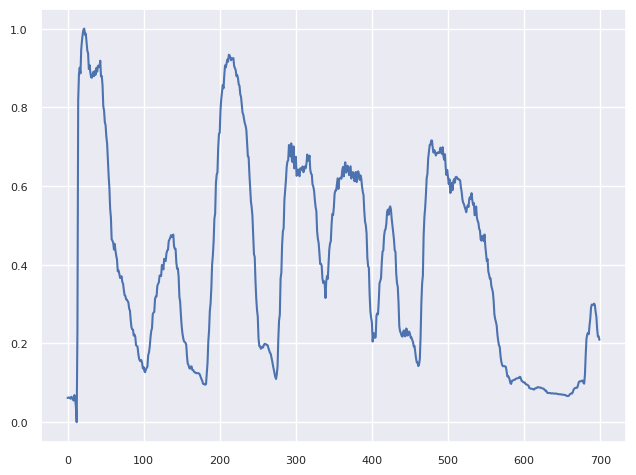

In [67]:
Y = np.zeros((len(std_phon), len(std_phon.standard_phonetic_trace[0])))

for i in range(len(std_phon)):
    Y[i] = std_phon.standard_phonetic_trace.values[i]
Y = Y.astype(float).reshape(-1, len(Y[0]))
print(Y.shape, Y.dtype)
# Saves
np.save(os.path.join(TS_PREPROC_FOLDER, f"std_phon_trace.npy"), std_phon.standard_phonetic_trace.values)

plt.plot(Y[0])


## Division in syllables
As a test, I try to divide the signal into adaptive windows corresponding to the syllables

- kidz-a-taw-kin-by-the-doo
- dogz-a-sit-ting-by-the-doo


In [56]:
from phonetic_stuff import SyllablesDivider

# Defines the syllable divider
divider = SyllablesDivider(n_syllables=7,
                           min_size_ms=0.0, 
                           smoothing_window_ms=20.0  ,
                           endpoint=True
                          )

divider.fit(ph_list)
print(sys.getsizeof(divider)*1e-6)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:05<00:00, 478.68it/s]

4.8e-05


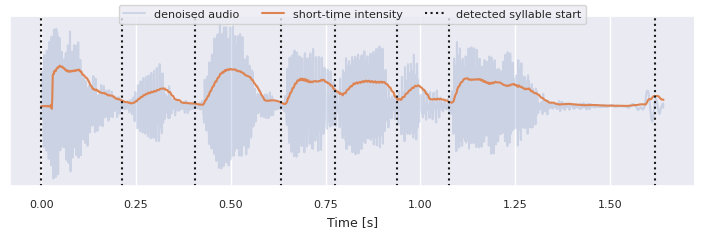

In [57]:
# Plots for a test track
test_track_index = 0 # 795

fig, ax = plt.subplots(figsize=default_style.SHORT_FULLSIZE_FIGURE)

ax.plot(ph_list.source_times[test_track_index], 
        ph_list.source_tracks[test_track_index], 
        alpha=0.2, label="denoised audio")

ax.plot(ph_list.times[test_track_index],
        ph_list.tracks[test_track_index], 
        label="short-time intensity")

flag=False
for st in divider.start_times[test_track_index]:
    ax.axvline(st, color="k", ls=":", label="detected syllable start" if not flag else "")
    flag=True
    
ax.set_xlabel("Time [s]")
ax.set_yticks([])
fig.legend(loc="upper center", ncols=3)
fig.tight_layout()
plt.savefig("../images/timeseries_syllables.pdf")

### Duration and intensity
Since now we can split the audio trace in bins that are adapted to the speech, it could be (generally speaking) feasible tounderstand the properties of accents by analysis of the relative intensities of the syllables and their relative duration.

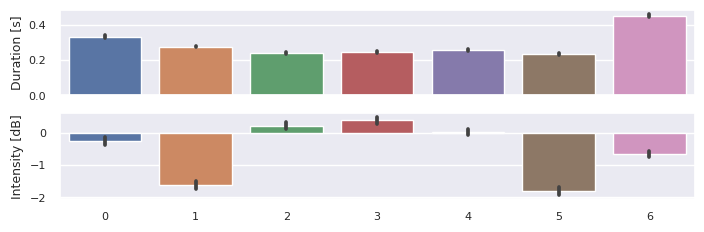

In [58]:
# Some stats of the syllables
fig, (ax1, ax2) = plt.subplots(2,1, figsize=default_style.SHORT_FULLSIZE_FIGURE, sharex=True)

sns.barplot(divider.duration_ms, ax=ax1)
sns.barplot(divider.intensities, ax=ax2)

ax1.set_ylabel("Duration [s]");
ax2.set_ylabel("Intensity [dB]");

<Axes: ylabel='Count'>

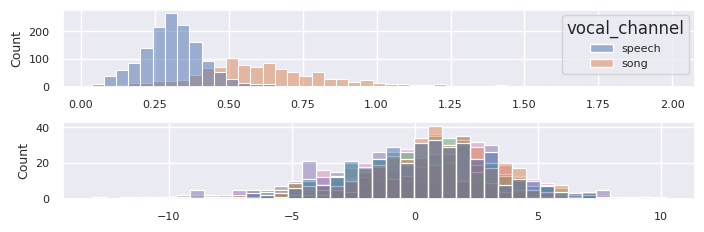

In [59]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=default_style.SHORT_FULLSIZE_FIGURE)

sns.histplot(x=divider.duration_ms[:,6], hue=df.vocal_channel, ax=ax1)
sns.histplot(x=divider.intensities[:,2], hue=df.emotion, ax=ax2, legend=False)

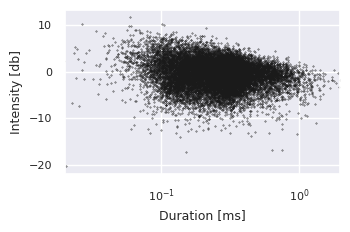

In [21]:
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
plt.scatter(divider.duration_ms.reshape(-1), divider.intensities.reshape(-1), 
            s=0.1, color="k", edgecolor=None)
plt.xscale("log")
plt.xlim(2e-2, 2);

plt.xlabel("Duration [ms]")
plt.ylabel("Intensity [db]")

plt.savefig("../images/syllables_pca.pdf")

In [22]:
# Saves the indexes in original track
for syll in range(8):
    df[f"syll_{syll}_start_index"] = ph_list.get_indexes_in_original_audios(np.array(divider.start_indexes)[:, syll])


### Embedding plot for syllables

In [23]:
from sklearn.manifold import Isomap
from umap import UMAP
from sklearn.decomposition import PCA

reducer = PCA(n_components=2)
embedding = reducer.fit_transform(np.append(divider.intensities, np.log10(divider.duration_ms), axis=1))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualen

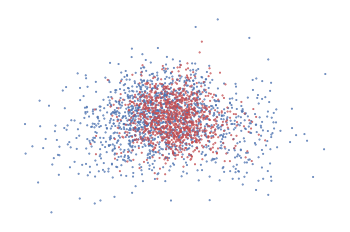

In [24]:
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
plt.scatter(embedding[:,0],embedding[:,1], c=df.vocal_channel.replace(dict(song="r", speech="b")), s=0.2)
plt.axis("off")
plt.savefig("../images/syllables_pca.pdf")

## Sequence padding

In order to be saved, timeseries must be made of the same length by adding NaNs or zeros.

In [25]:
df_to_save = df.copy()

In [26]:
# Standardizes the arrays
trace_cols = [col for col in df_to_save.columns if col.endswith("trace")]
padded_traces = dict()
for col in trace_cols:
    X = df[col].values

    # find the max length of X
    maximum = 0
    for ts in X:
        length = len(np.asarray(np.ravel(ts)))
        if length > maximum:
            maximum = length
    print(col, maximum)
    
    Y = np.zeros((len(X), maximum))
    for i in range(len(X)):
        Y[i] = np.pad(X[i],
                      (0, maximum - len(X[i])),
                     constant_values=(np.nan, np.nan))
    np.save(os.path.join(TS_PREPROC_FOLDER, f"{col}.npy"), Y)
    padded_traces[col] = Y

clean_trace 30154


In [27]:
df_to_save.drop(columns=[c for c in df_to_save.columns if c.endswith("trace")], inplace=True)
df_to_save.to_csv(DF_PREPROC_FILE)
del df_to_save

## Fourier stuff

Here some checks on the real Fourier spectrum are performed. In particular:

- does paddding with zeros modify the spectrum? --> yes
- how can a spectrum look in comparison to the spectrum of the spectrum of the syllables? --> still ugly as shit

by Nyquist theorem --> max f = 3.0 kHz


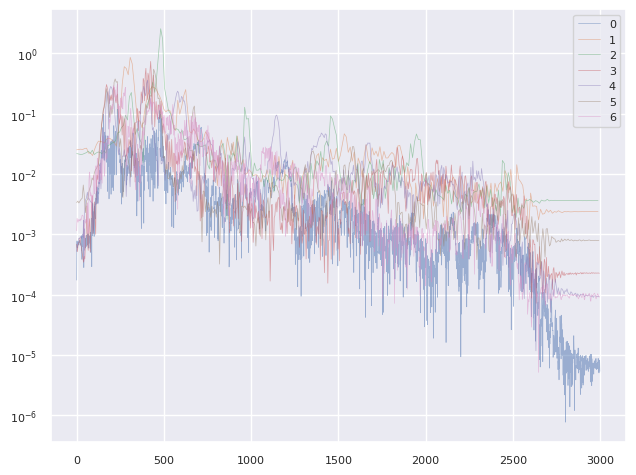

In [28]:
# Check on complete Fourier transform: syllables vs total
test_track = 10

for syll in range(7):
    signal = padded_traces["clean_trace"][test_track][df[f"syll_{syll}_start_index"][test_track]:df[f"syll_{syll+1}_start_index"][test_track]]
    signal[np.isnan(signal)] = 0.0
    
    N = len(signal)
    T = DECIMATION_FACTOR/SAMPLING_RATE

    signal_f = fft(signal)
    freqs = fftfreq(N, T)[:N//2]

    plt.plot(freqs, 2.0/N * np.abs(signal_f[0:N//2]), alpha=0.5,lw=0.5,label=syll)

signal = padded_traces["clean_trace"][test_track]
signal[np.isnan(signal)] = 0.0

N = len(signal)
T = DECIMATION_FACTOR/SAMPLING_RATE
#     print(f"T = {T*1e3:.2f} ms")
print(f"by Nyquist theorem --> max f = {0.5*SAMPLING_RATE/DECIMATION_FACTOR*1e-3} kHz")
signal_f = fft(signal)
freqs = fftfreq(N, T)[:N//2]
# plt.plot(freqs, 2.0/N * np.abs(signal_f[0:N//2]), color="k", lw=0.5)
plt.yscale("log")
plt.legend()

by Nyquist theorem --> max f = 3.0 kHz
by Nyquist theorem --> max f = 3.0 kHz


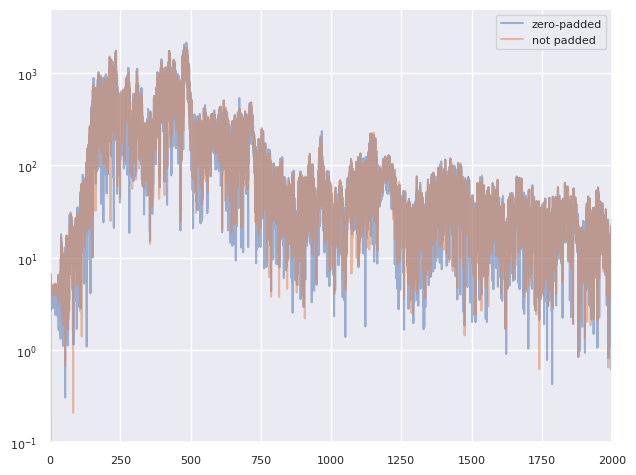

In [29]:
# Check differences on padded trace
test_track = 10

for tr, trname in zip([padded_traces["clean_trace"], df["clean_trace"].values], ["zero-padded", "not padded"]):
    signal = tr[test_track]
    signal[np.isnan(signal)] = 0.0
    N = len(signal)
    
    print(f"by Nyquist theorem --> max f = {0.5*SAMPLING_RATE/DECIMATION_FACTOR*1e-3} kHz")
    signal_f = fft(signal)
    freqs = fftfreq(N, T)[:N//2]
    plt.plot(freqs, 2.0 * np.abs(signal_f[0:N//2]), alpha=0.5, label=trname)
plt.xlim(0,2000)
plt.yscale("log")
plt.ylim(1e-1, 5e3)
plt.legend()

## Fourier approximation

As staten [here](https://openproceedings.org/2012/conf/edbt/SchaferH12.pdf) the Symbolic Fourier Approximation (implmented next cell) uses a particular binning of fourier coefficients and is **not equivalent to** just taking the first `n_coefs` coefficients (0Hz, 1Hz, etc.) of the fft.

In [30]:
from pyts.approximation import DiscreteFourierTransform

n_coefs = 100
fourier_approx = DiscreteFourierTransform(n_coefs=n_coefs)

X = padded_traces["clean_trace"]

del padded_traces
del ph_list

X[np.isnan(X)] = 0.0

Y = fourier_approx.fit_transform(X)
np.save(os.path.join(TS_PREPROC_FOLDER, "traces_fourier.npy"), Y)

In [31]:
reducer = UMAP(n_neighbors = 20)
embedding = reducer.fit_transform(Y)

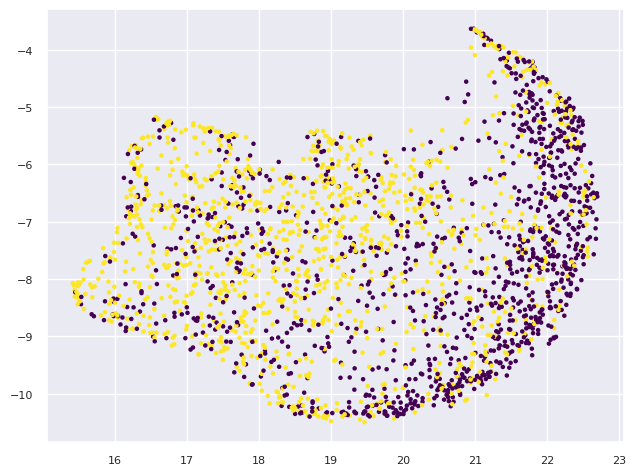

In [32]:
plt.scatter(*embedding.T, c=pd.Categorical(df.sex).codes, s=5, cmap="viridis")

### Symbolic Fourier for syllables
For each syllable number (i.e. all firsts syllables):
- take the longest one
- pad all the others to be the same length
- make fourier coefficients

This is not the right way to use a SFA since all the dataset is used to getthe most important Fourier coefficients,
but it cannot be done in other ways due to the huge amount of memory required.

In [33]:
X = divider.transform()
print("X has size", sys.getsizeof(X)*1e-6,"MB")

print("start fourier transforming sylls")
Y = np.zeros((divider.n_syllables, len(X[0]), 1000) )
print(Y.shape)
fourier_approx = DiscreteFourierTransform(n_coefs=1000,drop_sum=True)
for i in range(divider.n_syllables):
    print(f"X[{i}] has {np.sum(np.isnan(X[i]))} NaNs")
    X[i][np.isnan(X[i])] = 0.0
    Y[i] = fourier_approx.fit_transform(X[i])
    print("Y", i, "has size", sys.getsizeof(Y[i])*1e-6,"MB")

# Reshape to a list of fourier coefficients
# i.e. from [ (2452, 1000), (2452, 1000)  etc ]
# to [(7*2452, 1000)]
Y = Y.reshape(-1, Y.shape[2])
print("Y has final shape", Y.shape)
np.save(os.path.join(TS_PREPROC_FOLDER, f"syllables_fourier.npy"), Y)

# Labels of the syllables are then
# [0,0,0,0,0...., 1,1,1,1,1, ..., 2,2,2,2 etc]
# each label si repeated 2452 times
Y_labels = np.repeat(np.arange(7), len(Y[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.14it/s]


X has size 0.00011999999999999999 MB
start fourier transforming sylls
(7, 2452, 1000)
X[0] has 21623398 NaNs
Y 0 has size 0.000128 MB
X[1] has 17031792 NaNs
Y 1 has size 0.000128 MB
X[2] has 9487598 NaNs
Y 2 has size 0.000128 MB
X[3] has 12458070 NaNs
Y 3 has size 0.000128 MB
X[4] has 16790094 NaNs
Y 4 has size 0.000128 MB
X[5] has 18718038 NaNs
Y 5 has size 0.000128 MB
X[6] has 22467993 NaNs
Y 6 has size 0.000128 MB
Y has final shape (17164, 1000)
